# Outcome Analysis

## Housekeeping

In [83]:
# If in colab, mount drive and set wd
# If local, set wd to parent of notebook
import os
import re

try:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ds1_nhanes/')
except:
  from pathlib import Path
  if not re.search(r'ds1_nhanes$', str(os.getcwd())):
    os.chdir(Path(os.getcwd()).parent)

print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1-4PHX9XhMUWpi_lTsGHtTyz6s3O0u5a2/ds1_nhanes


Packages needed for this notebook:

In [84]:
# Utilities
import sys
import numpy as np
import pandas as pd

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Stat things
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Loading dataset with cluster assignments and HEI scores

In [85]:
df = pd.read_csv('data/clean/nhanes_2017_2023_hei.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11394 entries, 0 to 11393
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SEQN                       11394 non-null  int64  
 1   weight_2d                  11394 non-null  float64
 2   pf_total_(oz_eq)           11394 non-null  float64
 3   pf_legumes_(oz_eq)         11394 non-null  float64
 4   pf_nutsds_(oz_eq)          11394 non-null  float64
 5   pf_soy_(oz_eq)             11394 non-null  float64
 6   psu                        11394 non-null  int64  
 7   strata                     11394 non-null  int64  
 8   gender                     11394 non-null  object 
 9   age                        11394 non-null  int64  
 10  race                       11394 non-null  object 
 11  education                  11394 non-null  object 
 12  income_ratio               11394 non-null  float64
 13  total_cholesterol          11394 non-null  int

## Set up R Magic

Loading R libraries from Drive. Colab is a bottomless pit of despair, so instead of taking 20 minutes to install a couple of packages every time we start a session, we have saved some R packages to the drive that we can load much faster.

In [4]:
# Enables R magic
%load_ext rpy2.ipython

ERROR:rpy2.situation:Unable to determine R library path: Command '('/usr/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [5]:
%%R
# %%R has to be at the top of every cell that runs R

# This is adding our drive library to paths that R will check when it loads packages
.libPaths(c("dev/r_library/library", .libPaths()))

In [6]:
%%R
# Loading survey for complex survey analysis
library(survey)

# Also dplyr for various data wrangling functions
library(dplyr)

# Broom gives us nice clean tables
library(broom)

Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: ‘survey’

The following object is masked from ‘package:graphics’:

    dotchart


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Load some packages so that we can hand off data from R back to python

In [7]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

Load data:

In [8]:
%%R
# read.csv is like pd.read_csv
# Usually use '<-' instead of '=' for assigning objects, but either way works
dat <- read.csv('data/clean/nhanes_2017_2023_hei.csv')

# str() is like .info()
str(dat)

'data.frame':	11394 obs. of  41 variables:
 $ SEQN                     : int  109266 109271 109273 109274 109282 109284 109286 109290 109291 109293 ...
 $ weight_2d                : num  2994 7989 28256 6187 25233 ...
 $ pf_total_.oz_eq.         : num  2.79 19.54 8.14 7.48 7.22 ...
 $ pf_legumes_.oz_eq.       : num  1.63 0 0 0 0 ...
 $ pf_nutsds_.oz_eq.        : num  0.115 0 0 0 0.529 ...
 $ pf_soy_.oz_eq.           : num  0.783 0.072 0 0 0.012 0 0.009 0 0 0 ...
 $ psu                      : int  2 1 1 2 2 1 2 1 1 2 ...
 $ strata                   : int  168 167 155 167 164 154 154 171 161 163 ...
 $ gender                   : chr  "Female" "Male" "Male" "Male" ...
 $ age                      : int  29 49 36 68 76 44 33 68 42 44 ...
 $ race                     : chr  "Other or Multi" "White" "White" "Other or Multi" ...
 $ education                : chr  "College graduate or above" "9th to 11th grade" "Some college or AA" "Some college or AA" ...
 $ income_ratio             : num  5 0.

Do some cleaning to prepare to create survey design object

In [9]:
%%R
# Remove irrelevant columns
# We are using select and assigning the result back to dat
dat <- select(
    dat,
    psu,
    strata,
    weight_2d,
    gender:cluster
)

# Make characters factors, split age into bins
# Mutate function creates new columns
dat <- dat %>%
  mutate(
    gender = factor(gender),
    education = factor(education),
    race = factor(race),
    cluster = factor(cluster),
    age_bins = cut(
      age,
      breaks = c(-Inf, 19, 29, 39, 49, 59, Inf),
      labels = c(
        "<20",
        "20-29",
        "30-39",
        "40-49",
        "50-59",
        "60+"
      )
    )
  )

str(dat)

'data.frame':	11394 obs. of  14 variables:
 $ psu              : int  2 1 1 2 2 1 2 1 1 2 ...
 $ strata           : int  168 167 155 167 164 154 154 171 161 163 ...
 $ weight_2d        : num  2994 7989 28256 6187 25233 ...
 $ gender           : Factor w/ 2 levels "Female","Male": 1 2 2 2 2 1 1 1 1 2 ...
 $ age              : int  29 49 36 68 76 44 33 68 42 44 ...
 $ race             : Factor w/ 5 levels "Black","Mexican American",..: 4 5 5 4 5 2 4 1 4 5 ...
 $ education        : Factor w/ 6 levels "9th to 11th grade",..: 2 1 6 6 2 1 2 2 2 4 ...
 $ income_ratio     : num  5 0.67 0.83 1.2 3.61 3.15 1.36 5 5 0.02 ...
 $ total_cholesterol: int  195 147 164 105 233 212 236 165 229 189 ...
 $ blood_mercury    : num  0.36 0.42 0.51 0.2 0.31 0.54 1.44 1.22 0.6 0.63 ...
 $ avg_systolic_bp  : num  99 107 114 134 139 ...
 $ avg_diastolic_bp : num  54.3 67 67.3 70 72.7 ...
 $ cluster          : Factor w/ 4 levels "1","2","3","4": 2 1 2 2 2 2 4 3 3 2 ...
 $ age_bins         : Factor w/ 6 levels "<2

Make survey design object. This takes all the relics of our complex survey design and will incorporate it into any analyses. We will then use this 'design' object as the dataset for everything.

In [10]:
%%R
design <- svydesign(
  data = dat,
  id =  ~ psu,
  strata =  ~ strata,
  weights =  ~ weight_2d,
  nest = TRUE
)

Making a function that gives us our R2 for OLS models, because it is a bit different than OLS and not given by default:

In [11]:
%%R
get_r2 <- function(model, outcome_var, design = design) {
  # R2 = 1 - (Dispersion parameter / null model variance)
  # From Lumley, author of survey package
  # https://stats.stackexchange.com/questions/424092/how-to-run-svy-regress-in-r-or-get-r-squared-in-r-for-complex-survey-data

  if (family(model)$family != "gaussian") {
    stop("Only for linear models")
  }

  # Get dispersion parameter
  dispersion <- summary(model)$dispersion

  # Get null model variance
  variance <- svyvar(reformulate(outcome_var), design = design)[1]

  r2 <- 1 - (dispersion / variance)
  return(r2)
}

## Demographics with R

### Summary Stats

Even taking the mean of a variable depends on the study design. We get a point estimate as well as a standard error for everything.

In [12]:
%%R
svyby(~gender, ~cluster, design, svymean)

  cluster genderFemale genderMale se.genderFemale se.genderMale
1       1    0.1944165  0.8055835      0.01614570    0.01614570
2       2    0.5051140  0.4948860      0.01213715    0.01213715
3       3    0.6622618  0.3377382      0.01171178    0.01171178
4       4    0.4348834  0.5651166      0.01279363    0.01279363


In [13]:
%%R
svyby(~race, ~cluster, design, svymean)

  cluster  raceBlack raceMexican American raceOther Hispanic raceOther or Multi
1       1 0.08579168           0.10704779         0.06929704         0.10094448
2       2 0.11092543           0.07483329         0.07811883         0.08288185
3       3 0.13480745           0.07190603         0.10808537         0.10502382
4       4 0.09511043           0.08039464         0.07201406         0.11634500
  raceWhite se.raceBlack se.raceMexican American se.raceOther Hispanic
1 0.6369190  0.013492669              0.01926856           0.012264053
2 0.6532406  0.012595351              0.01602090           0.011163540
3 0.5801773  0.013626918              0.01171591           0.008742923
4 0.6361359  0.009997376              0.01454518           0.009260766
  se.raceOther or Multi se.raceWhite
1           0.022844892   0.02363821
2           0.007000351   0.02490116
3           0.008138409   0.01519911
4           0.010942694   0.01905850


In [14]:
%%R
svyby(~income_ratio, ~cluster, design, svymean, na.rm = TRUE)

  cluster income_ratio         se
1       1     3.107612 0.10671781
2       2     2.982891 0.06054728
3       3     2.881033 0.06230181
4       4     3.566905 0.06064719


Can break it down further with more variables, use these for graphs.

In [15]:
%%R
svyby(~income_ratio, ~cluster + gender, design, svymean)

         cluster gender income_ratio         se
1.Female       1 Female     2.854999 0.19936709
2.Female       2 Female     2.899111 0.07205914
3.Female       3 Female     2.857644 0.05980781
4.Female       4 Female     3.468803 0.08076050
1.Male         1   Male     3.168576 0.10060469
2.Male         2   Male     3.068403 0.07283174
3.Male         3   Male     2.926897 0.09522807
4.Male         4   Male     3.642400 0.07002786


### ANOVA

GLM with continuous y and categorical x is equivalent to ANOVA. It does not provide an F test, which shows whether there are differences overall. So we have to do it with the regTermTest() function, which provides a Wald test, the equivalent for working with this kind of data apparently.

In [16]:
%%R
income_model <- svyglm(income_ratio ~ cluster, design)
regTermTest(income_model, 'cluster')

Wald test for cluster
 in svyglm(formula = income_ratio ~ cluster, design = design)
F =  38.07908  on  3  and  37  df: p= 2.1153e-11 


Significant result says that income ratio differs across clusters.

To get regression output, we can just take summary of model object:

In [17]:
%%R
summary(income_model)


Call:
svyglm(formula = income_ratio ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.10761    0.10672  29.120  < 2e-16 ***
cluster2    -0.12472    0.10103  -1.235   0.2248    
cluster3    -0.22658    0.08887  -2.550   0.0151 *  
cluster4     0.45929    0.08299   5.534 2.68e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.660844)

Number of Fisher Scoring iterations: 2



Here, the first cluster (0) is not shown, and it is treated as the reference cluster. All other stats are interpreted in relation to the reference cluster. So, clusters 1 and 3 are significantly different from cluster 0, but 2 is not different from 0.

To get an R^2, we can use the function we made above, get_r2(). Note that this is only for linera models. For logistic or poisson models, we can use the built-in function psrsq().

In [18]:
%%R
get_r2(
    model = income_model,
    outcome_var = 'income_ratio',
    design = design
)

             variance     SE
income_ratio 0.024347 0.0542


Clusters explain 2.6% of variance in income_ratio

### GLM

Can do linear, logistic, poisson, etc., and include covariates here. Estimate effect of cluster while holding demographics constant

In [19]:
%%R
blood_merc_1 <- svyglm(blood_mercury ~ cluster + age + education + race + gender, design)
print(summary(blood_merc_1))


Call:
svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
                                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         0.203900   0.150179   1.358  0.18622    
cluster2                           -0.114799   0.079353  -1.447  0.15994    
cluster3                            0.143220   0.074765   1.916  0.06648 .  
cluster4                            0.360158   0.067383   5.345 1.36e-05 ***
age                                 0.010479   0.001437   7.292 9.60e-08 ***
educationCollege graduate or above  0.823125   0.088765   9.273 9.96e-10 ***
educationDon't know                 0.277322   0.113085   2.452  0.02122 *  
educationHigh school/GED            0.092625   0.067096   1.380  0.17919    
educationLess than 9th grade        0.404665   0.165476   2.445  0.02155 *  
edu

Can compared nested models with anova()

In [20]:
%%R
# Run another model with income, then compare
blood_merc_2 <- svyglm(blood_mercury ~ cluster + age + education + race + gender + income_ratio, design)

# Compare with anova
print(anova(blood_merc_1, blood_merc_2))
# model2 is better

Working (Rao-Scott+F) LRT for income_ratio
 in svyglm(formula = blood_mercury ~ cluster + age + education + 
    race + gender + income_ratio, design = design)
Working 2logLR =  51.97645 p= 1.6443e-07 
df=1;  denominator df= 25


Significant result suggests more complex model is preferred

Print confidence intervals:

In [21]:
%%R
print(confint(blood_merc_2))

                                          2.5 %      97.5 %
(Intercept)                        -0.189020271  0.43287640
cluster2                           -0.270347615  0.05458496
cluster3                           -0.005736202  0.30336410
cluster4                            0.197430395  0.47781181
age                                 0.006591235  0.01249944
educationCollege graduate or above  0.430806174  0.77198234
educationDon't know                -0.017841763  0.39725433
educationHigh school/GED           -0.095935592  0.15341015
educationLess than 9th grade        0.093495300  0.75976448
educationSome college or AA         0.057035977  0.28470813
raceMexican American               -0.378308712  0.07227183
raceOther Hispanic                 -0.186309856  0.15978122
raceOther or Multi                  0.117840834  0.63659353
raceWhite                          -0.461852268 -0.10159982
genderMale                          0.040712388  0.21536633
income_ratio                        0.07

Get R2 of model:

In [22]:
%%R
get_r2(blood_merc_2, 'blood_mercury', design = design)

              variance    SE
blood_mercury 0.076121 0.335


In [33]:
%%R
#dataframe = dat
# GLM : mercury ~ cluster

merc_glm <- svyglm(blood_mercury ~ cluster, design)
print(summary(merc_glm))


Call:
svyglm(formula = blood_mercury ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.06736    0.08228  12.972 2.45e-15 ***
cluster2    -0.13740    0.08064  -1.704   0.0968 .  
cluster3     0.13605    0.06940   1.960   0.0575 .  
cluster4     0.52656    0.07335   7.179 1.64e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3.066165)

Number of Fisher Scoring iterations: 2



In [38]:
%%R
# GLM : total_cholesterol ~ cluster
tot_chol_glm <- svyglm(total_cholesterol ~ cluster, design)
print(summary(tot_chol_glm))



Call:
svyglm(formula = total_cholesterol ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  183.438      1.556 117.879   <2e-16 ***
cluster2       3.615      1.682   2.149   0.0383 *  
cluster3       4.929      1.850   2.664   0.0114 *  
cluster4       4.431      1.746   2.538   0.0155 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1729.095)

Number of Fisher Scoring iterations: 2



In [47]:
%%R
# GLM : systolic_bp ~ cluster
systolic_bp_glm <-svyglm(avg_systolic_bp ~ cluster, design)
print(summary(systolic_bp_glm))



Call:
svyglm(formula = avg_systolic_bp ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 121.4829     0.5569 218.138  < 2e-16 ***
cluster2     -2.1839     0.7149  -3.055  0.00416 ** 
cluster3     -0.4286     0.6939  -0.618  0.54057    
cluster4     -0.2420     0.5919  -0.409  0.68506    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 290.0994)

Number of Fisher Scoring iterations: 2



In [50]:
%%R
# GLM : avg_diastolic_bp ~ cluster
diastolic_bp_glm <- svyglm(avg_diastolic_bp ~ cluster, design)
print(summary(diastolic_bp_glm))


Call:
svyglm(formula = avg_diastolic_bp ~ cluster, design = design)

Survey design:
svydesign(data = dat, id = ~psu, strata = ~strata, weights = ~weight_2d, 
    nest = TRUE)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  74.7798     0.4527 165.168  < 2e-16 ***
cluster2     -1.4416     0.4603  -3.132  0.00339 ** 
cluster3     -0.8112     0.5619  -1.444  0.15728    
cluster4     -1.4934     0.4870  -3.067  0.00403 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 116.2808)

Number of Fisher Scoring iterations: 2



In [76]:
%%R
# Summary stats of biomarkers in clusters
library(dplyr)

dat_cluster_means <- dat %>%
  group_by(cluster) %>%
  summarize(
    mean_blood_mercury = mean(blood_mercury, na.rm = TRUE),
    mean_total_cholesterol = mean(total_cholesterol, na.rm = TRUE),
    mean_avg_systolic_bp = mean(avg_systolic_bp, na.rm = TRUE),
    mean_avg_diastolic_bp = mean(avg_diastolic_bp, na.rm = TRUE)
  )
print(dat_cluster_means)
write.csv(dat_cluster_means, "cluster_means.csv", row.names = FALSE)


# A tibble: 4 × 5
  cluster mean_blood_mercury mean_total_cholesterol mean_avg_systolic_bp
  <fct>                <dbl>                  <dbl>                <dbl>
1 1                    1.08                    182.                 123.
2 2                    0.885                   185.                 122.
3 3                    1.21                    187.                 124.
4 4                    1.76                    187.                 124.
# ℹ 1 more variable: mean_avg_diastolic_bp <dbl>


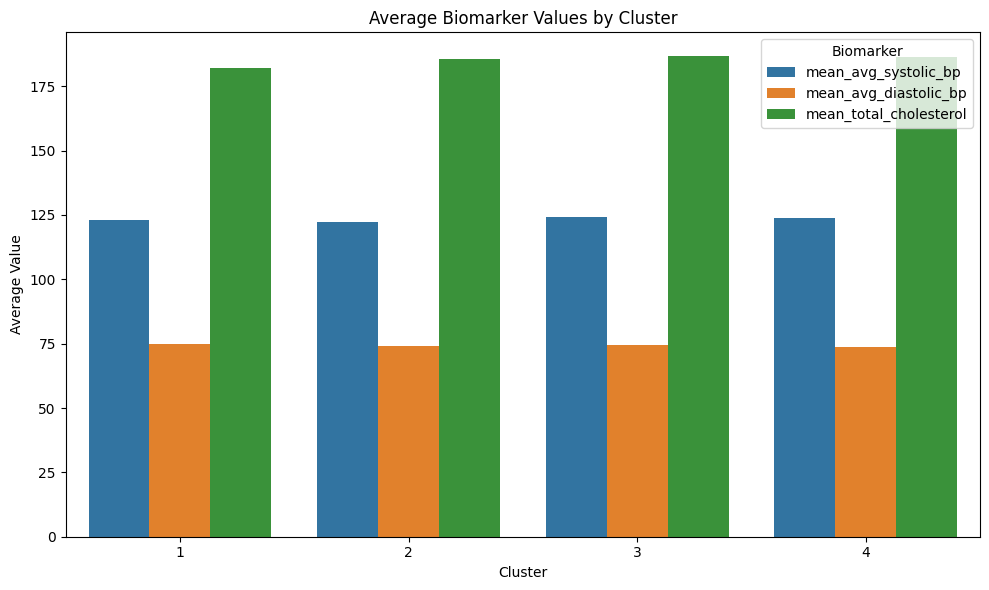

In [82]:
# Biomarker ~ Cluster Visualizations
dat_cluster_means = pd.read_csv('cluster_means.csv')

# Create a dataframe
cluster_means= pd.DataFrame(dat_cluster_means)

# Melt the dataframe for easier plotting
cluster_means_melted = cluster_means.melt(id_vars='cluster',
                    value_vars=['mean_avg_systolic_bp', 'mean_avg_diastolic_bp', 'mean_total_cholesterol'],
                    var_name='Biomarker', value_name='Average Value')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='cluster', y='Average Value', hue='Biomarker', data=cluster_means_melted)

# Customize the plot
plt.title('Average Biomarker Values by Cluster')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.legend(title='Biomarker')
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Plot mercury seperately as its scale is different to other biomarkers



Overall, model accounts for 11% of variance in blood mercury

### Python handoff, outputs

Hand off the R object back to python so we can make graphs or latex tables of whatever:

In [43]:
%%R
r_table <- svyby(~race, ~cluster, design, svymean)

In [44]:
# Pull into python
race_table = pandas2ri.rpy2py(robjects.globalenv['r_table'])
print(f"Raw table:\n{race_table}")

# # Pull indexes back into column names
# race_table.reset_index(inplace=True)
# gender_table[['cluster', 'gender']] = gender_table['index'].str.split('.', expand=True)

# # Drop old index
# gender_table.drop(columns=['index'], inplace=True)

# print(f"\nAfter cleaning:\n{gender_table}")

Raw table:
   cluster  raceBlack  raceMexican American  raceOther Hispanic  \
1        1   0.106145              0.086169            0.079441   
2        2   0.097825              0.103095            0.076038   
3        3   0.088059              0.053142            0.063752   
4        4   0.129628              0.096671            0.105700   

   raceOther or Multi  raceWhite  se.raceBlack  se.raceMexican American  \
1            0.112610   0.615636      0.010866                 0.014986   
2            0.099498   0.623544      0.011739                 0.019621   
3            0.073980   0.721067      0.014541                 0.017419   
4            0.117769   0.550231      0.011950                 0.013421   

   se.raceOther Hispanic  se.raceOther or Multi  se.raceWhite  
1               0.009029               0.010047      0.019441  
2               0.010263               0.012781      0.022013  
3               0.011857               0.013567      0.027761  
4               0.009

In [45]:
# Melt to make it long format for seaborn
race_long = race_table.melt(
    id_vars='cluster',
    var_name='race',
    value_name='mean_income_ratio'
)


Note that underscores mess everything up. Best to remove them or escape them with \_ before putting into latex. Also changing gender

In [46]:
gender_table.columns = gender_table.columns.str.replace('_', ' ')
print(gender_table)

NameError: name 'gender_table' is not defined

In [47]:
# Probably not the most exciting table but whatever
# Save to temp folder as an example
table.to_latex(
  'outputs/temp/example.tex',
  index=False,
  float_format="%.3f",
  caption='A super important table',
  position='h'
)

NameError: name 'table' is not defined

In [ ]:
# Make a graph out of our table


## PBP Consumption Analysis

### Weighted and Unweighted Means: PBP Consumption

In [48]:
from IPython.display import display

# Unweighted means

means_table = df.groupby('cluster')[['pf_soy_(oz_eq)','pf_legumes_(oz_eq)', 'pf_nutsds_(oz_eq)']].mean()

display(means_table.round(4))

# Weighted means

def weighted_mean(x, value_col, weight_col):
    return (x[value_col] * x[weight_col]).sum() / x[weight_col].sum()

weighted_means = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'wt_mean_pf_soy_(oz_eq)': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'wt_mean_pf_legumes_(oz_eq)': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'wt_mean_pf_nutsds_(oz_eq)': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d')
    })
).reset_index()

display(weighted_means.round(4))

,pf_soy_(oz_eq),pf_legumes_(oz_eq),pf_nutsds_(oz_eq)
cluster,,,
1,0.2599,1.4109,2.9642
2,0.1455,0.8724,1.3393
3,0.1186,0.9387,1.4437
4,0.1016,0.5415,0.6752


<ipython-input-48-e631b68a648e>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = df.groupby('cluster').apply(


,cluster,wt_mean_pf_soy_(oz_eq),wt_mean_pf_legumes_(oz_eq),wt_mean_pf_nutsds_(oz_eq)
0,1,0.2880,1.3688,3.2327
1,2,0.1558,0.8557,1.5178
2,3,0.1827,0.8744,1.5086
3,4,0.1200,0.5807,0.7763


### Descriptive Statistics

In [49]:
# Descriptive Stats: Unweighted Soy Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_soy_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

          count    mean     std  min  25%  50%    75%      max
cluster                                                       
1        3184.0  0.2599  1.0165  0.0  0.0  0.0  0.000  26.6560
2        3102.0  0.1455  0.6249  0.0  0.0  0.0  0.004  16.3886
3         594.0  0.1186  0.5024  0.0  0.0  0.0  0.000   4.1992
4        9826.0  0.1016  0.4712  0.0  0.0  0.0  0.000  10.2489


In [50]:
# Descriptive Stats: Unweighted Legume Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_legumes_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

          count    mean     std  min  25%  50%     75%      max
cluster                                                        
1        3184.0  1.4109  2.9865  0.0  0.0  0.0  1.7030  29.7741
2        3102.0  0.8724  2.0025  0.0  0.0  0.0  0.7414  23.8160
3         594.0  0.9387  2.1788  0.0  0.0  0.0  0.7751  19.9343
4        9826.0  0.5415  1.3954  0.0  0.0  0.0  0.1062  23.8160


In [51]:
# Descriptive Stats: Unweighted Nuts & Seeds Consumption by Cluster

descriptive_unweighted = df.groupby('cluster')['pf_nutsds_(oz_eq)'].describe()
print(descriptive_unweighted.round(4))

          count    mean     std  min  25%     50%     75%      max
cluster                                                           
1        3184.0  2.9642  4.9085  0.0  0.0  0.8967  4.0000  65.8470
2        3102.0  1.3393  2.6182  0.0  0.0  0.1690  1.7203  32.0215
3         594.0  1.4437  2.9735  0.0  0.0  0.0000  1.6446  21.2297
4        9826.0  0.6752  1.3980  0.0  0.0  0.0000  0.6669  15.4395


In [41]:
#Descriptive Stats: Weighted Soy Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_soy_(oz_eq)', 'weight_2d'),
        'min': g['pf_soy_(oz_eq)'].min(),
        '25%': g['pf_soy_(oz_eq)'].quantile(0.25),
        'median': g['pf_soy_(oz_eq)'].median(),
        '75%': g['pf_soy_(oz_eq)'].quantile(0.75),
        'max': g['pf_soy_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))

NameError: name 'weighted_std' is not defined

In [37]:
#Descriptive Stats: Weighted Legume Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_legumes_(oz_eq)', 'weight_2d'),
        'min': g['pf_legumes_(oz_eq)'].min(),
        '25%': g['pf_legumes_(oz_eq)'].quantile(0.25),
        'median': g['pf_legumes_(oz_eq)'].median(),
        '75%': g['pf_legumes_(oz_eq)'].quantile(0.75),
        'max': g['pf_legumes_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))

NameError: name 'weighted_std' is not defined

In [ ]:
#Descriptive Stats: Weighted Nuts & Seeds Consumption by Cluster

desc_weighted = df.groupby('cluster').apply(
    lambda g: pd.Series({
        'weighted_mean': weighted_mean(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
        'weighted_std': weighted_std(g, 'pf_nutsds_(oz_eq)', 'weight_2d'),
        'min': g['pf_nutsds_(oz_eq)'].min(),
        '25%': g['pf_nutsds_(oz_eq)'].quantile(0.25),
        'median': g['pf_nutsds_(oz_eq)'].median(),
        '75%': g['pf_nutsds_(oz_eq)'].quantile(0.75),
        'max': g['pf_nutsds_(oz_eq)'].max(),
    })
).reset_index()

print(desc_weighted.round(3).to_string(index=False))